# step 1

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

#  Load and Normalize the Dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0 # Normalize pixel values to range [0,1]

# Data Augmentation to improve model generalization
train_datagen = ImageDataGenerator(
    rotation_range=15,# Random rotation by 15 degrees
    width_shift_range=0.1,# Horizontal shift by 10%
    height_shift_range=0.1,# Vertical shift by 10%
    horizontal_flip=True,# Randomly flip images horizontally
    zoom_range=0.1# Random zoom by 10%
)
train_datagen.fit(train_images) #Apply transformations to training images


Step 2

In [10]:

#  Build the Optimized CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),  # First convolution layer
    layers.BatchNormalization(),  # Normalize activations
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Second convolution layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),  # Reduce spatial dimensions
    layers.Dropout(0.3),  # Reduce overfitting

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Third convolution layer
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Fourth convolution layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Fifth convolution layer
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Sixth convolution layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),  # Flatten feature maps to a vector
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10)  # Output layer with 10 classes
])

# Step 3:

In [11]:
# Compile the Model
from tensorflow.keras.optimizers import AdamW
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
              # AdamW optimizer for better generalization
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for classification
              metrics=['accuracy'])

# Learning Rate Scheduler to dynamically adjust learning rate
def lr_scheduler(epoch, lr):
    return lr * 0.95 if epoch > 10 else lr  # Reduce learning rate after 10 epochs

# Callbacks for early stopping and learning rate adjustment
lr_callback = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# step 4

In [12]:
# Train the Model
history = model.fit(train_datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=50, # Train for 50 epochs
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping,])# Stop training early if no improvement


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.3036 - loss: 2.2081 - val_accuracy: 0.5107 - val_loss: 1.3622
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5036 - loss: 1.3758 - val_accuracy: 0.5485 - val_loss: 1.3141
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5816 - loss: 1.1819 - val_accuracy: 0.5258 - val_loss: 1.3979
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6346 - loss: 1.0459 - val_accuracy: 0.6358 - val_loss: 1.0750
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6594 - loss: 0.9730 - val_accuracy: 0.6607 - val_loss: 1.0417
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6883 - loss: 0.9033 - val_accuracy: 0.6831 - val_loss: 0.9287
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.7028 - loss: 0.8593 - val_accuracy: 0.7091 - val_loss: 0.8339
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7182 - loss: 0.8266 - 

# step 5

In [13]:
# Evaluate the Model
_, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")

313/313 - 1s - 4ms/step - accuracy: 0.8530 - loss: 0.4409
Test accuracy: 85.30%


# Step 6:

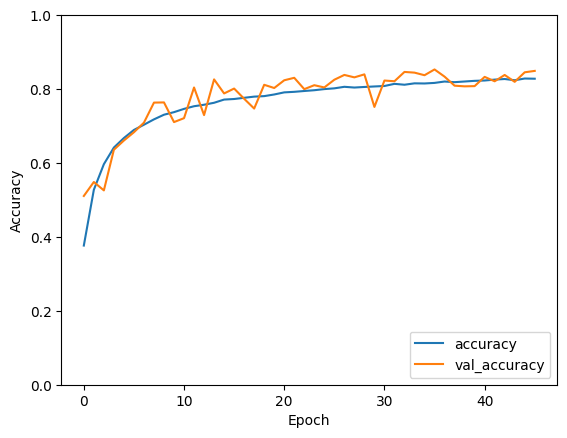

In [14]:
#  Visualize Training Results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


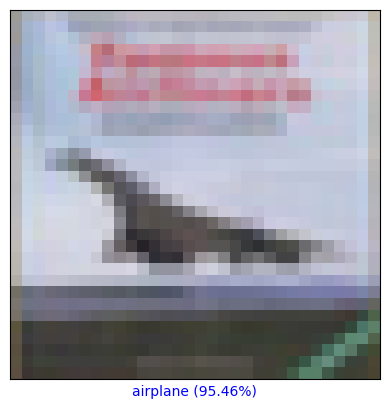

In [15]:

# Define class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Step 7: Make Predictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

# Function to display predictions
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i][0], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{class_names[predicted_label]} ({100*np.max(predictions_array):.2f}%)", color=color)

# Display prediction for a sample image
plt.figure()
plot_image(3, predictions[3], test_labels, test_images)
plt.show()
